## Amazon Book Reviews 
### Predicting Positve/ Negative rating based
### VADER for sentiment analysis



<p><img src="https://storage.googleapis.com/kaggle-datasets-images/2476732/4200454/a920661a0c1b326c27297c37bbec1f18/dataset-cover.jpg?t=2022-09-13-23-08-14" /><br /></p>

Firstly, I will perfrom classification using three different 'classic' claffication models, and access and evaluate the results/

Secondly, I will have a look at Vader, pretrained model for sentiment analysis.

wordcloud PyPI
nltk PyPI
com.microsoft.azure:synapseml-vw_2.12:0.10.1 Maven

https://www.kaggle.com/code/akashbangalkar3/amazon-kindle-reviews-acc-score-93/data

##1. Read the Data from DBFS to our Notebook

In [0]:
# spark.read.csv() method to load a CSV file from DBFS (Databricks File System) using PySpark.
from pyspark.sql import SparkSession

# Bootstrap Spark Session
spark = SparkSession.builder.getOrCreate()

In [0]:
df = spark.read.csv("dbfs:/FileStore/tables/w4/all_kindle_review_.csv", header=True, inferSchema=True)

df.show(5)

+---+----------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|_c0|Unnamed: 0|      asin|helpful|rating|          reviewText|          reviewTime|          reviewerID|        reviewerName|             summary|unixReviewTime|
+---+----------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|  0|     11539|B0033UV8HI|[8, 10]|     3|"Jace Rankin may ...| amongst other cr...| and she's not so...| so she hides beh...| she has to come ...|   we find out|
|  1|      5957|B002HJV4DE| [1, 1]|     5|Great short read....|          10 8, 2013|      A2RGNZ0TRF578I|        Holly Butler|Terrific menage s...|    1381190400|
|  2|      9146|B002ZG96I4| [0, 0]|     3|I'll start by say...|         04 11, 2014|      A3S0H2HV6U1I7F|             Merissa|    Snapdragon Alley|    1397174400|
|  3|      7038|B002QH

In [0]:
from pyspark.sql.functions import isnull, when, count, col

df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+---+----------+----+-------+------+----------+----------+----------+------------+-------+--------------+
|_c0|Unnamed: 0|asin|helpful|rating|reviewText|reviewTime|reviewerID|reviewerName|summary|unixReviewTime|
+---+----------+----+-------+------+----------+----------+----------+------------+-------+--------------+
|  0|         0|   0|      1|     1|         1|         1|         1|          36|      3|             2|
+---+----------+----+-------+------+----------+----------+----------+------------+-------+--------------+



In [0]:
df.dropna()

Out[459]: DataFrame[_c0: string, Unnamed: 0: string, asin: string, helpful: string, rating: int, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, summary: string, unixReviewTime: string]

In [0]:
from pyspark.sql.functions import isnull

df_without_nulls = df.filter(~isnull(df["rating"]))
df_without_nulls.show()


+---+----------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|_c0|Unnamed: 0|      asin|helpful|rating|          reviewText|          reviewTime|          reviewerID|        reviewerName|             summary|      unixReviewTime|
+---+----------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|     11539|B0033UV8HI|[8, 10]|     3|"Jace Rankin may ...| amongst other cr...| and she's not so...| so she hides beh...| she has to come ...|         we find out|
|  1|      5957|B002HJV4DE| [1, 1]|     5|Great short read....|          10 8, 2013|      A2RGNZ0TRF578I|        Holly Butler|Terrific menage s...|          1381190400|
|  2|      9146|B002ZG96I4| [0, 0]|     3|I'll start by say...|         04 11, 2014|      A3S0H2HV6U1I7F|             Merissa|    Snapdragon Alley|        

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import UserDefinedFunction
#view some summary of the columns
df.describe("rating").show()


+-------+-----------------+
|summary|           rating|
+-------+-----------------+
|  count|            12000|
|   mean|             3.25|
| stddev|1.421619411145559|
|    min|                1|
|    max|                5|
+-------+-----------------+



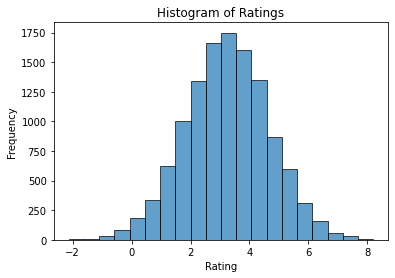

In [0]:
import matplotlib.pyplot as plt
import numpy as np

mean = 3.25
stddev = 1.42

ratings = np.random.normal(mean, stddev, 12000)

plt.hist(ratings, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings')
plt.show()


In [0]:
ratingCount = df.groupBy("rating").count()
ratingCount.show()

+------+-----+
|rating|count|
+------+-----+
|     1| 2000|
|     3| 2000|
|     5| 3000|
|     4| 3000|
|     2| 2000|
|  null|    1|
+------+-----+



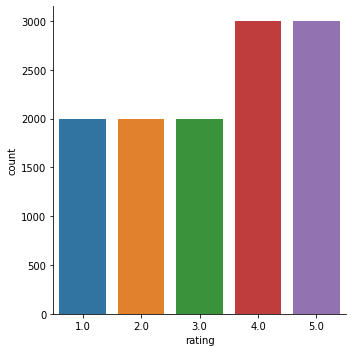

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spark DataFrame to a Pandas DataFrame
rating_count = ratingCount.toPandas()

# Create the catplot using Seaborn
sns.catplot(x="rating", y="count", kind="bar", data=rating_count)

# Show the plot
plt.show()


In [0]:
# Create temporary view for visualisation
df.createOrReplaceTempView("tempdf")

In [0]:
%sql
-- Organize by Type
select rating, count(1) from tempdf group by rating

rating count(1) 1 2000 3 2000 5 3000 4 3000 2 2000 null 1

In [0]:
# Select required columns that we need for ML
df = df.select(
  "rating",
  "reviewText")


In [0]:
from pyspark.sql.functions import min
from pyspark.sql.functions import when

# count the number of samples in each class
counts = df.groupBy("rating").count().collect()


## 2. Prepare the Data for ML Models

### UDT & Transformation

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

#first UDF is wordCount
def wordCount(s):
    return len(s.split())

#second UDF is wordLength
def wordLength(s):
    import numpy as np

    ss = [len(w) for w in s.split()]
    return round(float(np.mean(ss)), 2)

#registered UDFs can then be used in DataFrame operations
wordLengthUDF = udf(wordLength, DoubleType())
wordCountUDF = udf(wordCount, IntegerType())

In [0]:
from synapse.ml.stages import *
from pyspark.sql.functions import udf
from synapse.ml.stages import UDFTransformer

wordLength = "wordLength"
wordCount = "wordCount"
wordLengthTransformer = UDFTransformer(
    inputCol="reviewText", outputCol=wordLength, udf=wordLengthUDF
)
wordCountTransformer = UDFTransformer(
    inputCol="reviewText", outputCol=wordCount, udf=wordCountUDF
)

In [0]:
df.columns

Out[471]: ['rating', 'reviewText']

In [0]:
# Remove ma's - easier at this stage with a limited dataframe
df = df.dropna(subset=["reviewText"])

###Pipeline Building

In [0]:
# the 3 is used to differenciate between possitive (more than 3) & negative (less than 3 rating)
from pyspark.ml import Pipeline

dataPipeline = (
    Pipeline(stages=[wordLengthTransformer, wordCountTransformer])
    .fit(df)
    .transform(df)
    .withColumn("label", df["rating"] > 3)
    .drop("rating")
)

In [0]:
dataPipeline.show(10)

+--------------------+----------+---------+-----+
|          reviewText|wordLength|wordCount|label|
+--------------------+----------+---------+-----+
|"Jace Rankin may ...|       4.2|      156|false|
|Great short read....|      4.33|       69| true|
|I'll start by say...|      4.49|       76|false|
|Aggie is Angela L...|      5.22|       54|false|
|I did not expect ...|      3.55|       20| true|
|Aislinn is a litt...|       4.9|      263| true|
|This has the maki...|      4.62|       80|false|
|I got this becaus...|       4.3|      218| true|
|Loved this book, ...|      4.52|       25| true|
|And that's a good...|      4.13|       23| true|
+--------------------+----------+---------+-----+
only showing top 10 rows



###Featurzation & Tokenization

In [0]:
from pyspark.ml.feature import Tokenizer, HashingTF
from pyspark.ml.feature import VectorAssembler

# Featurize text column
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokenizedText")
numFeatures = 10000
hashingScheme = HashingTF(
    inputCol="tokenizedText", outputCol="TextFeatures", numFeatures=2000
)
tokenizedData = tokenizer.transform(dataPipeline)
featurizedData = hashingScheme.transform(tokenizedData)

# Merge text and numeric features in one feature column
featureColumnsArray = ["TextFeatures", "wordCount", "wordLength"]
assembler = VectorAssembler(inputCols=featureColumnsArray, outputCol="features")
assembledData = assembler.transform(featurizedData)

# Select only columns of interest
# Convert rating column from boolean to int
processedData = assembledData.select("label", "features").withColumn(
    "label", assembledData.label.cast(IntegerType())
)

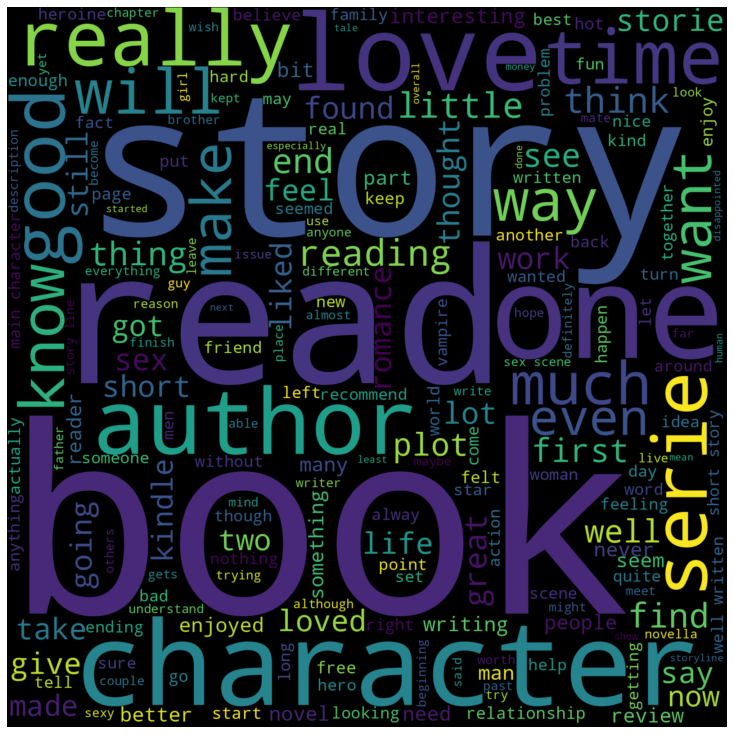

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Extract the tokenized text column
tokenizedText = tokenizedData.select("tokenizedText").rdd.flatMap(lambda x: x).collect()

# join the lists in tokenizedText to create a single string
tokenizedText = ' '.join([' '.join(elem) for elem in tokenizedText])

# Create a word cloud from the tokenized text
wordcloud = WordCloud(width=1600, height=1600).generate(tokenizedText)


# Display the wordCloud
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [0]:
processedData.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(2002,[17,31,49,6...|
|    1|(2002,[17,55,80,1...|
|    0|(2002,[15,17,48,5...|
|    0|(2002,[17,31,125,...|
|    1|(2002,[393,488,49...|
|    1|(2002,[12,17,24,4...|
|    0|(2002,[17,48,66,7...|
|    1|(2002,[10,17,39,4...|
|    1|(2002,[0,112,197,...|
|    1|(2002,[17,168,334...|
|    0|(2002,[17,112,166...|
|    1|(2002,[17,307,338...|
|    0|(2002,[17,114,133...|
|    1|(2002,[14,17,37,4...|
|    1|(2002,[17,106,133...|
|    0|(2002,[17,48,100,...|
|    1|(2002,[17,37,112,...|
|    0|(2002,[17,116,206...|
|    1|(2002,[17,240,301...|
|    1|(2002,[17,59,66,7...|
+-----+--------------------+
only showing top 20 rows



### Check if the Classes are balanced

In [0]:
ratingCount = processedData.groupBy("label").count()
ratingCount.show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 6000|
|    0| 6000|
+-----+-----+



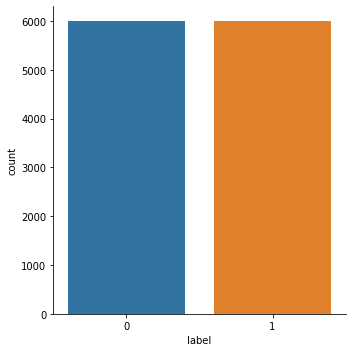

In [0]:
# Convert the Spark DataFrame to a Pandas DataFrame
rating_count = ratingCount.toPandas()

# Create the catplot using Seaborn
sns.catplot(x="label", y="count", kind="bar", data=rating_count)

# Show the plot
plt.show()


##3.Model Building & Evaluation

In [0]:
# Prepare data for learning
train, test, validation = processedData.randomSplit([0.8, 0.1, 0.1])

###Tradional Linear Models: Logistic Regression & Linear SVM

### Logistic Regression

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

# Train the models on the 'train' data
lrHyperParams = [0.05, 0.1, 0.2, 0.4]
logisticRegressions = [
    LogisticRegression(regParam=hyperParam) for hyperParam in lrHyperParams
]
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)
metrics = []
models = []

# Select the best model
for learner in logisticRegressions:
    model = learner.fit(train)
    models.append(model)
    scoredData = model.transform(test)
    metrics.append(evaluator.evaluate(scoredData))
bestMetric = max(metrics)
bestModel = models[metrics.index(bestMetric)]

# Get AUC on the validation dataset
predictionVal = bestModel.transform(validation)
print(evaluator.evaluate(predictionVal))

0.8521269975184812


In [0]:
# Check the accuracy of the model
correct_predictions = predictionVal.filter(predictionVal.label == predictionVal.prediction).count()
total_predictions = predictionVal.count()
accuracy = correct_predictions / total_predictions
print("Accuracy:", accuracy)

Accuracy: 0.7790322580645161


###Logistic regression Evaluation

In [0]:
import pandas as pd

# calculates the accuracy and AUC of the predictions  
correct_predictions = predictionVal.filter(predictionVal.label == predictionVal.prediction).count()
total_predictions = predictionVal.count()
accuracy = correct_predictions / total_predictions
auc = evaluator.evaluate(predictionVal)

results = [["Accuracy", accuracy], ["AUC", auc]]
df_lr = pd.DataFrame(results, columns=["Metric", "Value"])

print(df_lr)


     Metric     Value
0  Accuracy  0.779032
1       AUC  0.852127


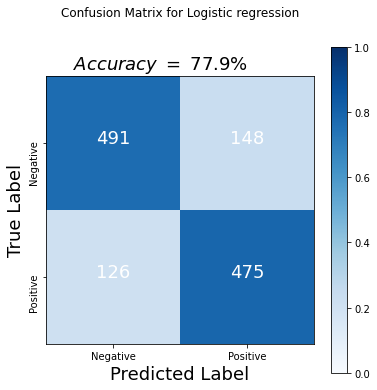

In [0]:
# confusion Matrix for Log regression

def plotConfusionMatrix(df_lr, label, prediction, classLabels):
    from synapse.ml.plot import confusionMatrix
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(6, 6))
    confusionMatrix(predictionVal, label, prediction, classLabels)
    plt.title("Confusion Matrix for Logistic regression", y=1.20)

plotConfusionMatrix(model.transform(validation), "label", "prediction", ['Negative', 'Positive'])

The accuracy reported in the confusion matrix plot is the number of correct predictions divided by the total number of predictions, whereas the AUC score measures the performance of a binary classifier as a whole, taking into account both the true positive rate and the false positive rate.

###Linear SVC

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LinearSVC

# Train the models on the 'train' data
svmHyperParams = [0.01, 0.05, 0.1]
svmModels = [LinearSVC(regParam=hyperParam) for hyperParam in svmHyperParams]
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)
metrics = []
models = []

# Select the best model
for learner in svmModels:
    model = learner.fit(train)
    models.append(model)
    scoredData = model.transform(test)
    metrics.append(evaluator.evaluate(scoredData))
bestMetric = max(metrics)
bestModel = models[metrics.index(bestMetric)]

# Get AUC on the validation dataset
predictionVal1 = bestModel.transform(validation)
print(evaluator.evaluate(predictionVal1))


0.8379773929210296


In [0]:
# calculates the accuracy and AUC of the predictions  
correct_predictions = predictionVal1.filter(predictionVal1.label == predictionVal1.prediction).count()
total_predictions = predictionVal1.count()
accuracy = correct_predictions / total_predictions
auc = evaluator.evaluate(predictionVal1)

results = [["Accuracy", accuracy], ["AUC", auc]]
df_svm = pd.DataFrame(results, columns=["Metric", "Value"])

print(df_svm)


     Metric     Value
0  Accuracy  0.768548
1       AUC  0.837977


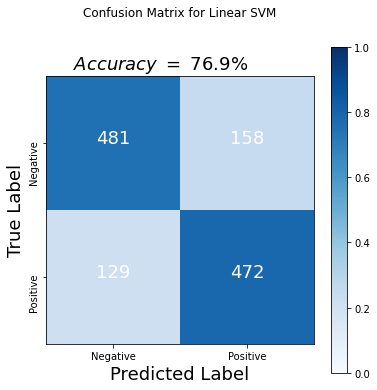

In [0]:
# confusion Matrix for Linear SVM
def plotConfusionMatrix(df_svm, label, prediction, classLabels):
    from synapse.ml.plot import confusionMatrix
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(6, 6))
    confusionMatrix(predictionVal1, label, prediction, classLabels)
    plt.title("Confusion Matrix for Linear SVM", y=1.20)

plotConfusionMatrix(model.transform(validation), "label", "prediction", ['Negative', 'Positive'])

###Modern Models: Decsion Tree and Naive Bayes

### Decision Tree

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier

# Train the models on the 'train' data
dtHyperParams = [2, 3, 4, 5, 6]
dtModels = [DecisionTreeClassifier(maxDepth=hyperParam) for hyperParam in dtHyperParams]
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)
metrics = []
models = []

# Select the best model
for learner in dtModels:
    model = learner.fit(train)
    models.append(model)
    scoredData = model.transform(test)
    metrics.append(evaluator.evaluate(scoredData))
bestMetric = max(metrics)
bestModel = models[metrics.index(bestMetric)]

# Get AUC on the validation dataset
predictionVal2 = bestModel.transform(validation)
print(evaluator.evaluate(predictionVal2))


0.5874663771127412


In [0]:
# calculates the accuracy and AUC of the predictions  
correct_predictions = predictionVal2.filter(predictionVal2.label == predictionVal2.prediction).count()
total_predictions = predictionVal2.count()
accuracy = correct_predictions / total_predictions
auc = evaluator.evaluate(predictionVal2)

results = [["Accuracy", accuracy], ["AUC", auc]]
df_dt = pd.DataFrame(results, columns=["Metric", "Value"])

print(df_dt)

     Metric     Value
0  Accuracy  0.621774
1       AUC  0.587466


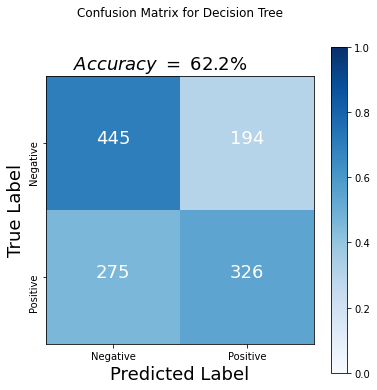

In [0]:
# confusion matrix for dt
def plotConfusionMatrix(df_dt, label, prediction, classLabels):
    from synapse.ml.plot import confusionMatrix
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(6, 6))
    confusionMatrix(predictionVal2, label, prediction, classLabels)
    plt.title("Confusion Matrix for Decision Tree", y=1.20)
    
plotConfusionMatrix(model.transform(validation), "label", "prediction", ['Negative', 'Positive'])

### Naive bayes

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import NaiveBayes

# Train the models on the 'train' data
nbHyperParams = [0.05, 0.1, 0.2, 0.4]
naiveBayesModels = [NaiveBayes(smoothing=hyperParam) for hyperParam in nbHyperParams]
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)
metrics = []
models = []

# Select the best model
for learner in naiveBayesModels:
    model = learner.fit(train)
    models.append(model)
    scoredData = model.transform(test)
    metrics.append(evaluator.evaluate(scoredData))
bestMetric = max(metrics)
bestModel = models[metrics.index(bestMetric)]

# Get AUC on the validation dataset
predictionVal3 = bestModel.transform(validation)
print(evaluator.evaluate(predictionVal3))


0.5244311124651403


In [0]:
# calculates the accuracy and AUC of the predictions  
correct_predictions = predictionVal3.filter(predictionVal3.label == predictionVal3.prediction).count()
total_predictions = predictionVal3.count()
accuracy = correct_predictions / total_predictions
auc = evaluator.evaluate(predictionVal3)

results = [["Accuracy", accuracy], ["AUC", auc]]
df_nb = pd.DataFrame(results, columns=["Metric", "Value"])

print(df_nb)

     Metric     Value
0  Accuracy  0.741129
1       AUC  0.524431


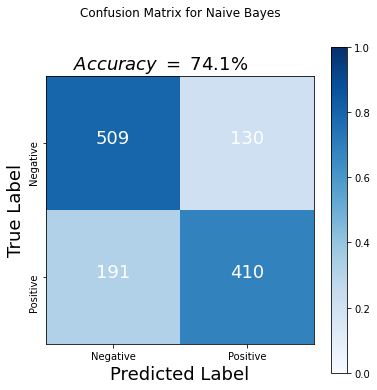

In [0]:
def plotConfusionMatrix(df_nb, label, prediction, classLabels):
    from synapse.ml.plot import confusionMatrix
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(6, 6))
    confusionMatrix(predictionVal3, label, prediction, classLabels)
    plt.title("Confusion Matrix for Naive Bayes", y=1.20)

plotConfusionMatrix(model.transform(validation), "label", "prediction", ['Negative', 'Positive'])

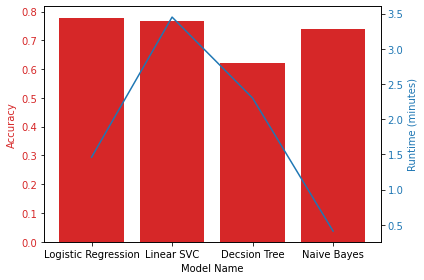

In [0]:
models = ['Logistic Regression', 'Linear SVC', 'Decsion Tree', 'Naive Bayes']
accuracies = [0.779032 , 0.768548 , 0.621774  ,0.741129]
runtimes = [1.46, 3.45, 2.30, 0.41]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Model Name')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(models, accuracies, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Runtime (minutes)', color=color)
ax2.plot(models, runtimes, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()


##4.PreTrained Models

## Vader Sentiment Analysis

In [0]:
df1 = spark.read.csv("dbfs:/FileStore/tables/w4/all_kindle_review_.csv", header=True, inferSchema=True)
 
df1.show(5)

+---+----------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|_c0|Unnamed: 0|      asin|helpful|rating|          reviewText|          reviewTime|          reviewerID|        reviewerName|             summary|unixReviewTime|
+---+----------+----------+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|  0|     11539|B0033UV8HI|[8, 10]|     3|"Jace Rankin may ...| amongst other cr...| and she's not so...| so she hides beh...| she has to come ...|   we find out|
|  1|      5957|B002HJV4DE| [1, 1]|     5|Great short read....|          10 8, 2013|      A2RGNZ0TRF578I|        Holly Butler|Terrific menage s...|    1381190400|
|  2|      9146|B002ZG96I4| [0, 0]|     3|I'll start by say...|         04 11, 2014|      A3S0H2HV6U1I7F|             Merissa|    Snapdragon Alley|    1397174400|
|  3|      7038|B002QH

In [0]:
# Select required columns
df1 = df1.select(
  "rating",
  "reviewText",)
df1.show(5) 

+------+--------------------+
|rating|          reviewText|
+------+--------------------+
|     3|"Jace Rankin may ...|
|     5|Great short read....|
|     3|I'll start by say...|
|     3|Aggie is Angela L...|
|     4|I did not expect ...|
+------+--------------------+
only showing top 5 rows



In [0]:
# Remove ma's - easier at this stage with a limited dataframe
df1 = df1.dropna(subset=["reviewText"])

In [0]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Out[550]: True

In [0]:
from nltk.sentiment import vader
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Create an instance of the sentiment analyzer
vader_analyzer = vader.SentimentIntensityAnalyzer()

# Create a UDF for the sentiment analysis
vader_sentiment = udf(lambda x: vader_analyzer.polarity_scores(x)['compound'] if x else None, DoubleType())

# Add a sentiment column to the dataframe
df1 = df1.withColumn("sentimentVADERrT", vader_sentiment("reviewText"))
df1.show(10)


+------+--------------------+----------------+
|rating|          reviewText|sentimentVADERrT|
+------+--------------------+----------------+
|     3|"Jace Rankin may ...|         -0.9816|
|     5|Great short read....|          0.9645|
|     3|I'll start by say...|          0.8555|
|     3|Aggie is Angela L...|          -0.128|
|     4|I did not expect ...|          0.4404|
|     5|Aislinn is a litt...|          0.9963|
|     2|This has the maki...|         -0.5106|
|     4|I got this becaus...|          0.9524|
|     5|Loved this book, ...|          0.7959|
|     4|And that's a good...|          0.5574|
+------+--------------------+----------------+
only showing top 10 rows



In [0]:
print(df1)

DataFrame[rating: int, reviewText: string, sentimentVADERrT: double]


In [0]:
# Remove ma's - easier at this stage with a limited dataframe
df1 = df1.dropna(subset=["reviewText"])

In [0]:
# quick eye check to see the numbers, look good
df1.where("rating == '5'").show(10)

+------+--------------------+----------------+
|rating|          reviewText|sentimentVADERrT|
+------+--------------------+----------------+
|     5|Great short read....|          0.9645|
|     5|Aislinn is a litt...|          0.9963|
|     5|Loved this book, ...|          0.7959|
|     5|But it's from the...|          0.1154|
|     5|i love j.r. wards...|           0.802|
|     5|I love reading mi...|          0.9937|
|     5|This book was ext...|          0.9308|
|     5|I found this book...|          0.8479|
|     5|Amy Parker is goi...|          0.9921|
|     5|It's Jodi's birth...|          0.9933|
+------+--------------------+----------------+
only showing top 10 rows



In [0]:
# quick eye check to see the numbers, look good
df1.where("rating == '1'").show(10)

+------+--------------------+----------------+
|rating|          reviewText|sentimentVADERrT|
+------+--------------------+----------------+
|     1|"I received a cop...|         -0.5267|
|     1|I read the other ...|         -0.7391|
|     1|How many times is...|         -0.5171|
|     1|I don't know what...|         -0.9143|
|     1|"This short story...|          -0.964|
|     1|No, not my type. ...|         -0.7762|
|     1|I can't believe t...|          0.8367|
|     1|This book is wron...|         -0.5801|
|     1|I am not a fan of...|         -0.6761|
|     1|This book was a c...|          0.8373|
+------+--------------------+----------------+
only showing top 10 rows



In [0]:
df1.dtypes

Out[556]: [('rating', 'int'), ('reviewText', 'string'), ('sentimentVADERrT', 'double')]

In [0]:
from pyspark.sql.functions import expr
df1 = df1.withColumn("rating", expr("cast(rating as float)"))

In [0]:
from pyspark.sql.functions import corr

correlation = df1.agg(corr("rating", "sentimentVADERrT")).first()[0]
print(f"Pearson correlation coefficient: {correlation}")


Pearson correlation coefficient: 0.4288471038012895


In [0]:
df1_panda = df1.toPandas()

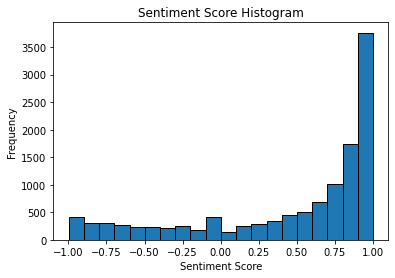

In [0]:
import matplotlib.pyplot as plt
 
# Plot the histogram of the sentiment column
plt.hist(df1_panda['sentimentVADERrT'], bins=20, edgecolor='k')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Histogram')
plt.show()
 

In [0]:
 
# Plot the histogram of the sentiment column
plt.hist(df1_panda['rating'], bins=20, edgecolor='k')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Histogram')
plt.show()
 

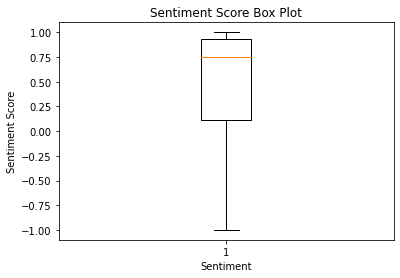

In [0]:
# Plot the box plot of the sentiment column
plt.boxplot(df1_panda['sentimentVADERrT'])
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score Box Plot')
plt.show()


##Visualisation: VADER

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import UserDefinedFunction
#view some summary of the columns
df1.describe("rating").show()

+-------+-----------------+
|summary|           rating|
+-------+-----------------+
|  count|            12000|
|   mean|             3.25|
| stddev|1.421619411145559|
|    min|              1.0|
|    max|              5.0|
+-------+-----------------+



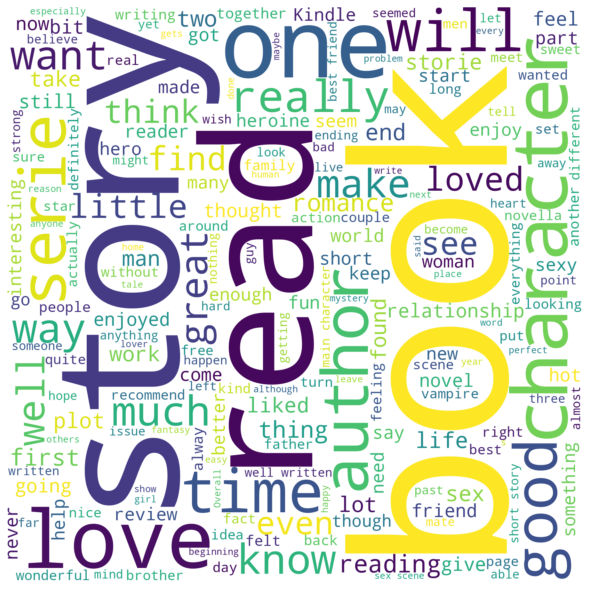

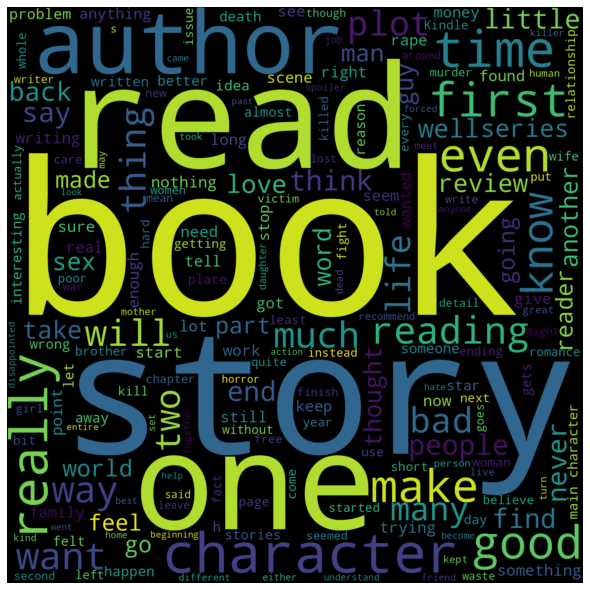

In [0]:
from pyspark.sql import SparkSession
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Filter the dataframe into two separate dataframes for positive and negative sentiment
positive_df = df1.filter(df1.sentimentVADERrT > 0.9)
negative_df = df1.filter(df1.sentimentVADERrT < - 0.9)

# Create the word clouds
positive_text = positive_df.select("reviewText").toPandas().reviewText.str.cat(sep=' ')
negative_text = negative_df.select("reviewText").toPandas().reviewText.str.cat(sep=' ')
stopwords = set(STOPWORDS)

positive_wordcloud = WordCloud(width = 1800, height = 1800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(positive_text)

negative_wordcloud = WordCloud(width = 1800, height = 1800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(negative_text)

# Plot the wordClouds

# Positive wordCloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Negative wordCloud

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

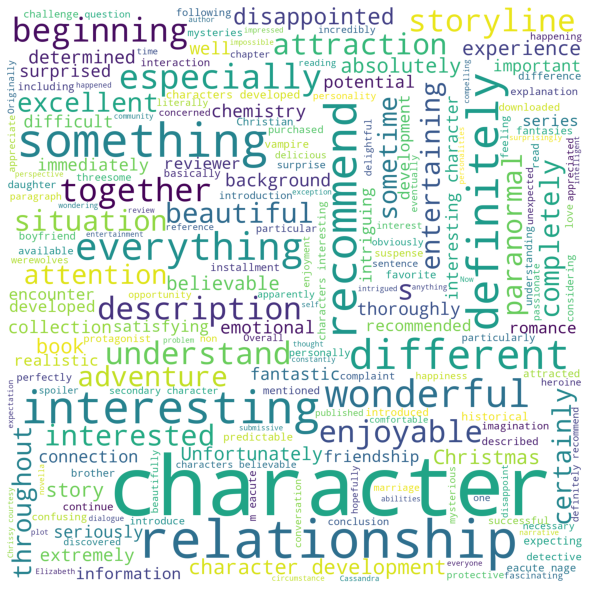

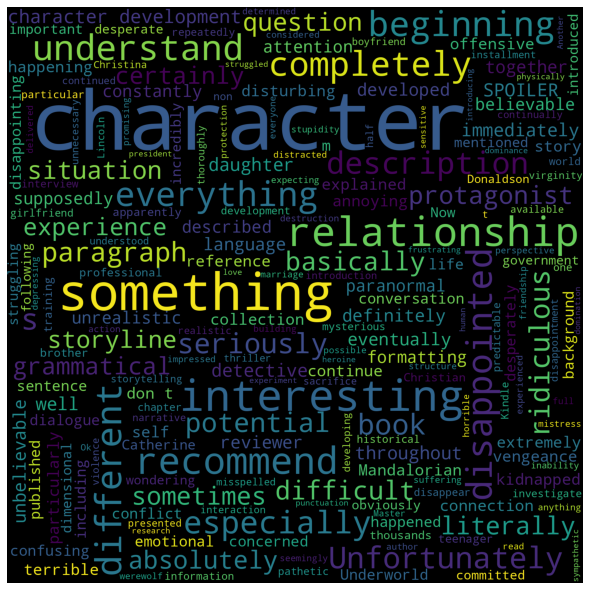

In [0]:
# Generate the wordcloud for only words with more than 5 characters
positive_text = " ".join(word for word in positive_text.split() if len(word) > 8)
positive_wordcloud = WordCloud(width = 1800, height = 1800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(positive_text)

negative_text = " ".join(word for word in negative_text.split() if len(word) > 8)
negative_wordcloud = WordCloud(width = 1800, height = 1800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(negative_text)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(positive_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(negative_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [0]:
# Initialize SentimentIntensityAnalyzer
analyzer = vader.SentimentIntensityAnalyzer()

# Add new columns to the dataframe to store sentiment scores
df1_panda['compound'] = df1_panda['reviewText'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df1_panda['positive'] = df1_panda['reviewText'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
df1_panda['negative'] = df1_panda['reviewText'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
df1_panda['neutral'] = df1_panda['reviewText'].apply(lambda x: analyzer.polarity_scores(x)['neu'])

# Filter the dataframe into separate dataframes for each sentiment
positive_df = df1_panda.query("compound > 0")
negative_df = df1_panda.query("compound < 0")
neutral_df = df1_panda.query("compound == 0")


In [0]:
print(df1_panda.head())

   rating                                         reviewText  \
0     3.0  "Jace Rankin may be short, but he's nothing to...   
1     5.0  Great short read.  I didn't want to put it dow...   
2     3.0  I'll start by saying this is the first of four...   
3     3.0  Aggie is Angela Lansbury who carries pocketboo...   
4     4.0  I did not expect this type of book to be in li...   

   sentimentVADERrT  compound  positive  negative  neutral  
0           -0.9816   -0.9816     0.069     0.190    0.741  
1            0.9645    0.9645     0.283     0.044    0.673  
2            0.8555    0.8555     0.138     0.000    0.862  
3           -0.1280   -0.1280     0.070     0.078    0.851  
4            0.4404    0.4404     0.139     0.000    0.861  
